In [3]:
#Importing libraries
import json
import pywt
import time
import requests
import datetime

import numpy as np
import pandas as pd
import pandas_ta as ta
import statsmodels.api as sm

import statsmodels.tsa.stattools as smStat

from matplotlib import pyplot as plt
from pykalman import KalmanFilter



In [4]:
#Reading Data and adding columns, spreads, etc
def requestData(reqAsset, reqInterval):
    reqFrom = round(time.time() - 60*reqInterval*720)
    req = requests.get('https://api.kraken.com/0/public/OHLC?pair={}&since={}&interval={}'.format(reqAsset, reqFrom, reqInterval))
    dic = list(json.loads(req.text)['result'])
    dic2 = json.loads(req.text)['result'][dic[0]]
    reqData = pd.DataFrame.from_dict(dic2)
    reqData.drop([5, 7], axis = 1, inplace=True)
    reqData.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    reqData.date = pd.to_datetime(reqData.date,  unit='s')
    reqData.set_index('date', inplace=True)
    reqData[['open', 'high', 'low', 'close', 'volume']] = reqData[['open', 'high', 'low', 'close', 'volume']].apply(pd.to_numeric, errors = 'coerce', axis = 1)
    return reqData

def addPercentReturn(dataframe):
    dataframe['percentReturn'] = (dataframe.close / dataframe.close.shift(1))
    dataframe.dropna(inplace=True)

def addLogReturn(dataframe):
    dataframe['logReturn'] = np.log(dataframe.close / dataframe.close.shift(1))
    dataframe.dropna(inplace=True)

def addLogPrice(dataframe):
    dataframe['logPrice'] = np.log(dataframe.close)
    dataframe.dropna(inplace=True)

def addStandardDifference(dataframe):
    dataframe['standardDifference'] = dataframe['close'].diff()
    dataframe.dropna(inplace=True)
        
def addSpreads(dataframe1, dataframe2):
    dataframe1['spread'] = dataframe1.logReturn - dataframe2.logReturn
    dataframe2['spread'] = dataframe2.logReturn - dataframe1.logReturn


def initData(assetList, interval):
    ''' Do not use '''
    assetDict = {}
    for i in assetList:
        assetRequest = requestData(i, interval)
        addStandardDifference(assetRequest)
        addPercentReturn(assetRequest)
        addLogReturn(assetRequest)
        addLogPrice(assetRequest)
        assetDict[i] = assetRequest
    for i in range(0, len(assetList)-1):
        addSpreads(assetDict[assetList[i]], assetDict[assetList[i+1]])
    return assetDict

def initData2(asset, interval):
    assetRequest = requestData(asset, interval)
    addStandardDifference(assetRequest)
    addPercentReturn(assetRequest)
    addLogReturn(assetRequest)
    addLogPrice(assetRequest)
    return assetRequest

def initCSVData(dataframe):
    addStandardDifference(dataframe)
    addPercentReturn(dataframe)
    addLogReturn(dataframe)
    addLogPrice(dataframe)
    return dataframe
    
    


In [ ]:
#Modifying sheet data
sheetNames = ['ADA','ETH','FTM','LINK','ONE','SOL','SAND']
fullData = [pd.read_excel('./dataCollection/Book1.xlsx', sheet_name = sheetNames[i]) for i in range(len(sheetNames))]
resampleData = [pd.DataFrame() for i in range(len(sheetNames))]

timeframeString = '5T'

def resamClose(arrayLike):
    return arrayLike[-1]

for i in range(len(sheetNames)):
    fullData[i]['date'] = pd.date_range(start = '1/1/2020', periods=len(fullData[i]), freq='30S')
    fullData[i].set_index('date', inplace=True)

    resampleData[i]['open'] = fullData[i]['open'].resample(timeframeString, convention='start').asfreq()
    resampleData[i]['high'] = fullData[i]['high'].resample(timeframeString).max()
    resampleData[i]['low'] = fullData[i]['low'].resample(timeframeString).min()
    resampleData[i]['close'] = fullData[i]['close'].resample(timeframeString, convention='end').apply(resamClose)

In [ ]:
#Rough Run

sheetNames = ['ADA','ETH','FTM','LINK','ONE','SOL','SAND']
fullData = [pd.read_excel('./dataCollection/Book1.xlsx', sheet_name = sheetNames[i]) for i in range(len(sheetNames))]

for q in range(len(sheetNames)):
    for p in range(len(sheetNames)):
        if q!=p:
            spread = []
            asset1 = initCSVData(fullData[q])
            asset2 = initCSVData(fullData[p])

            asset1 = asset1.head(45400)
            asset2 = asset2.head(45400)

            covMult = 0.002
            obsCov = 0.001

            kfInit = KalmanFilter(
                n_dim_state = 2,
                n_dim_obs= 1,
                transition_matrices=[[1,0],[0,1]], 
                transition_covariance=np.eye(2)*(covMult/(1-covMult)),
                observation_matrices=[[asset1.logPrice.iloc[0],1]],
                observation_covariance=obsCov
            )

            kfInit = kfInit.em(asset2.logPrice, n_iter=5)
            _kalMeansInit, _kalCovsInit = kfInit.filter(asset2.logPrice)
            _kalMeansInit, _kalCovsInit = kfInit.smooth(asset2.logPrice)

            kf = KalmanFilter(
                initial_state_mean=_kalMeansInit[-1],
                initial_state_covariance=_kalCovsInit[-1],
                transition_matrices=[[1,0],[0,1]], 
                transition_covariance=np.eye(2)*(covMult/(1-covMult)),
                observation_matrices=[[asset1.logPrice.iloc[0],1]],
                observation_covariance=obsCov
            )

            _kalMeans, _kalCovs = kf.filter(asset2.logPrice.iloc[0])
            kalMeans=[_kalMeans[0]]
            kalCovs=[_kalCovs[0]]

            for i in range(1,len(asset1.logPrice)):
                _kalMeans, _kalCovs = kf.filter_update(
                    kalMeans[-1],
                    kalCovs[-1],
                    observation=asset2.logPrice.iloc[i],
                    observation_matrix=np.array([[asset1.logPrice.iloc[i],1]])
                )
                kalMeans.append(_kalMeans)
                kalCovs.append(_kalCovs)

                spread.append(asset2.logPrice.iloc[i] - (np.array([[asset1.logPrice.iloc[i],1]])).dot(kalMeans[-1])[0])
                # spreadDev.append(np.sqrt((np.array([[asset1.logPrice.iloc[i],1]])).dot(kalCovs[-1] + np.eye(2)*covMult).dot((np.array([[asset1.logPrice.iloc[i],1]])).transpose())[0][0] + obsCov))

            spread = pd.Series(spread)
            kalDF = pd.DataFrame(kalMeans, columns=['mu', 'gamma'])

            oneLevel = smStat.adfuller(spread)[4]['1%']
            fiveLevel = smStat.adfuller(spread)[4]['5%']
            tenLevel = smStat.adfuller(spread)[4]['10%']
            testStat = smStat.adfuller(spread)[0]

            if (testStat < (tenLevel or fiveLevel or oneLevel)):

                print('Test Statistic: {}'.format(testStat))
                print('1%: {}, 5%: {}, 10%: {}'.format(oneLevel, fiveLevel, tenLevel))

                plt.figure(figsize = (30,10), dpi = 100)
                plt.subplot(2,1,1)
                plt.title('Kalman Mu and Gamma of {} and {}'.format(sheetNames[q], sheetNames[p]))
                plt.plot(kalDF.mu, c = 'w', label = 'Mu')
                plt.plot(kalDF.gamma, c='#82A0B2', label = 'Gamma')
                plt.xlabel('Index')
                plt.ylabel('Value')
                plt.legend(loc=2)

                plt.subplot(2,1,2)
                plt.title('Spread of {} and {}'.format(sheetNames[q], sheetNames[p]))
                plt.xlabel('Index')
                plt.ylabel('Spread')
                plt.plot(spread, c='r', label = 'Spread')
                # plt.plot(10*spread.std(), c='b', label = 'Spread Deviations')
                plt.axhline(10*spread.std(), c='b')
                plt.legend(loc=2)
                plt.show()
         

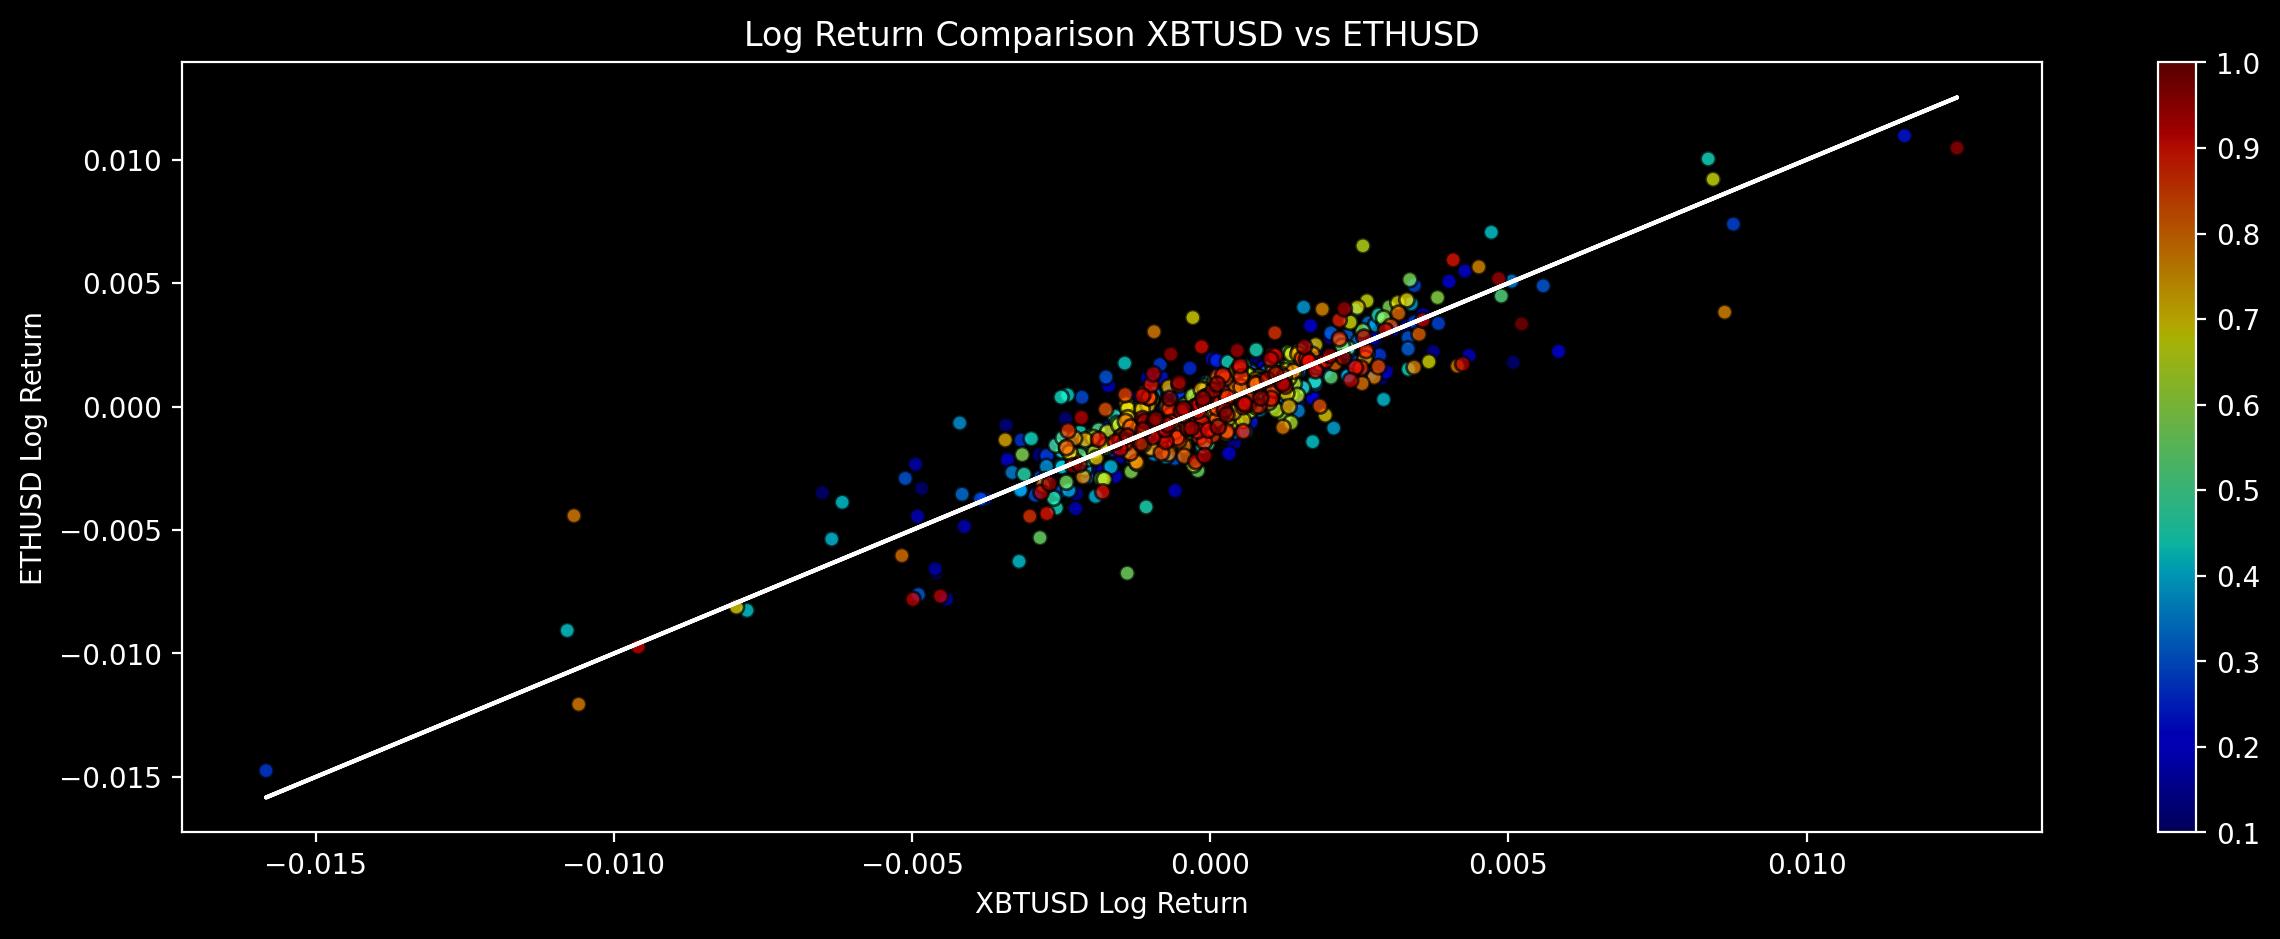

In [16]:
#Plotting Log Return. Add assets in a list

coin1 = assetDict[assetList[0]]
coin2 = assetDict[assetList[1]]

plt.figure(figsize = (15,5), dpi = 200)
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(coin1.logReturn))
sc = plt.scatter(coin1.logReturn, coin2.logReturn, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
plt.plot(coin1.logReturn, 1*coin1.logReturn, color = 'white')

plt.colorbar(sc)
plt.title('Log Return Comparison {} vs {}'.format(assetList[0], assetList[1]))
plt.xlabel('{} Log Return'.format(assetList[0]))
plt.ylabel('{} Log Return'.format(assetList[1]))
plt.show()

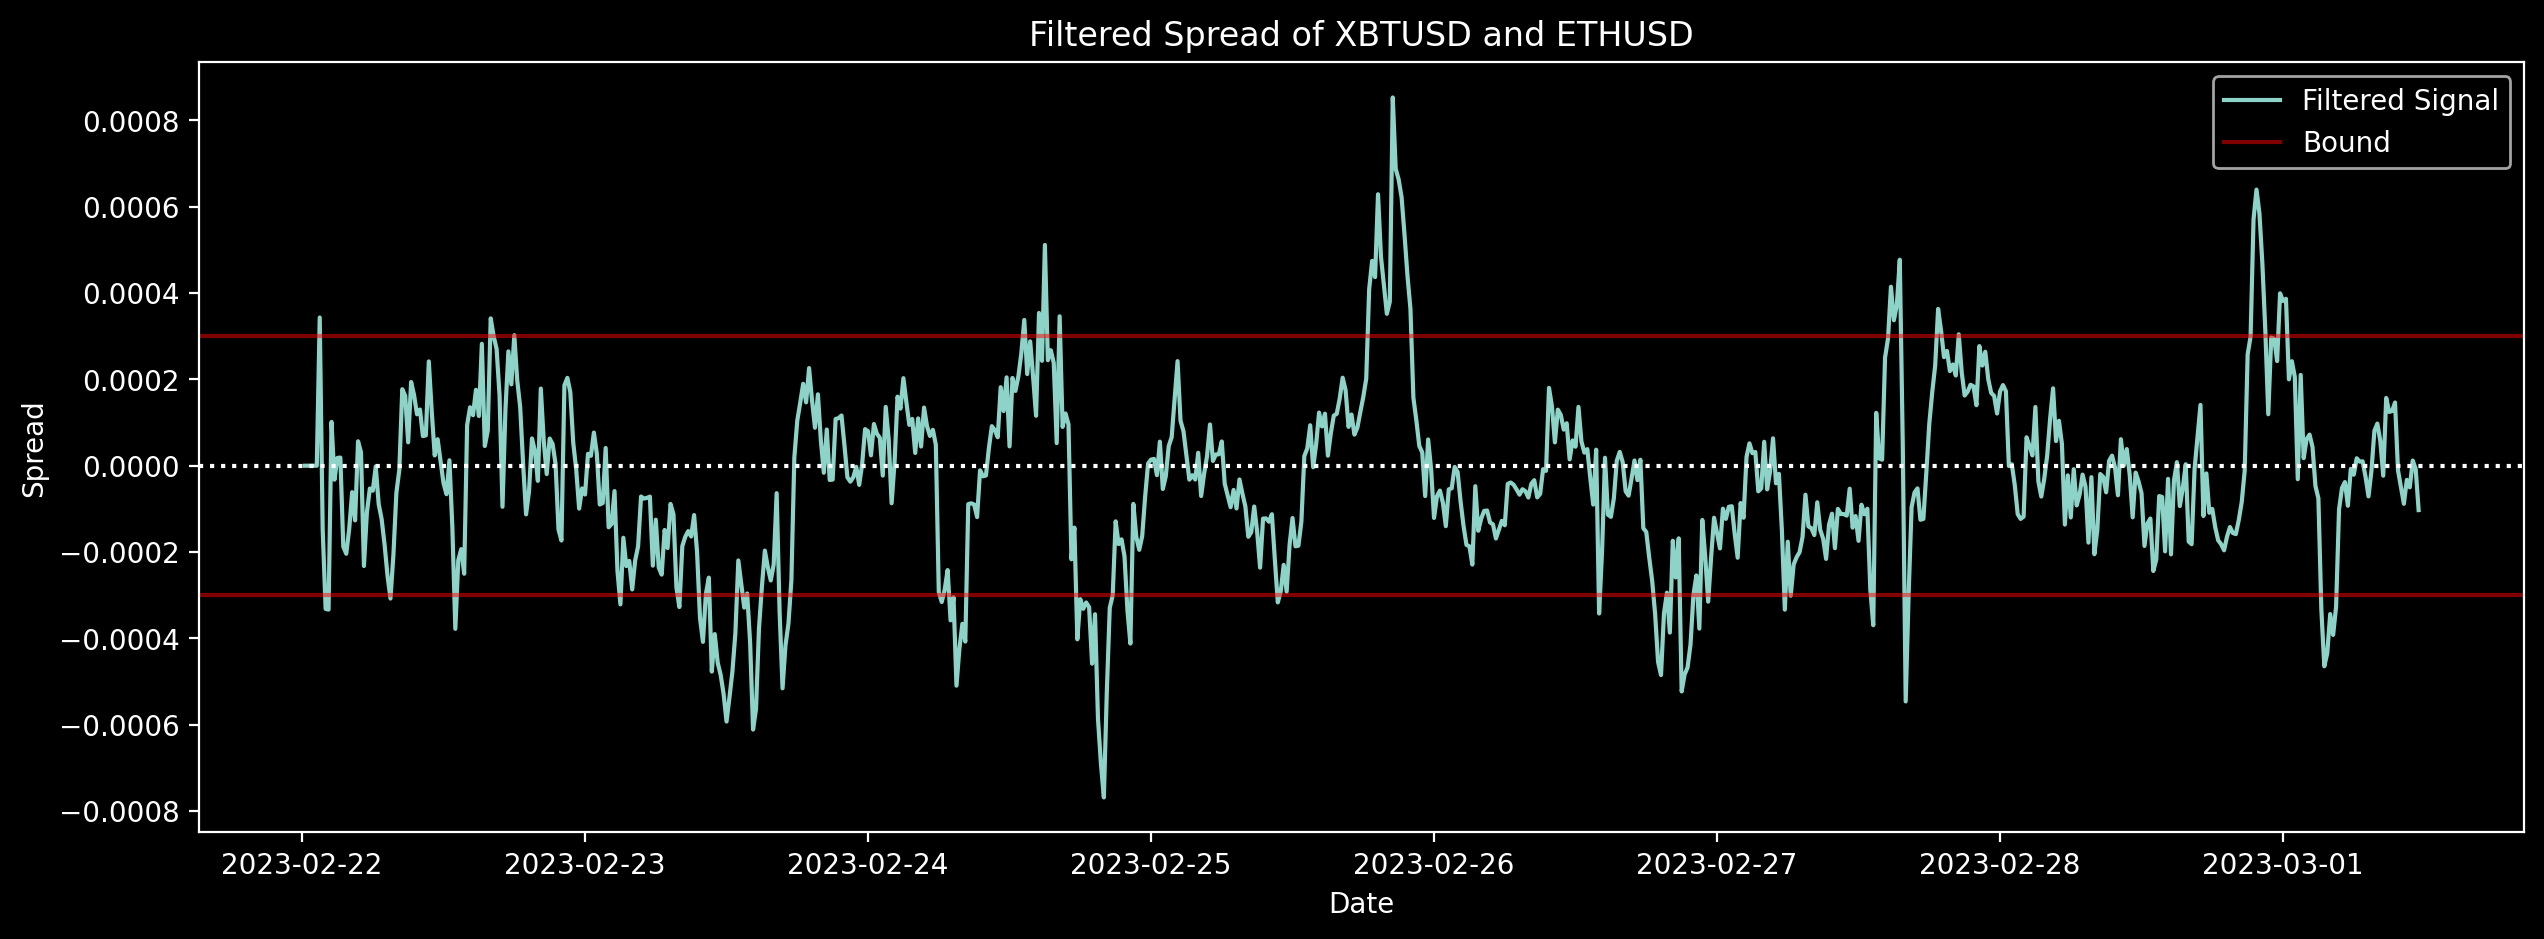

In [22]:
#Rudimentary Backtesting All
sheetNames = ['ADA','ETH','FTM','LINK','ONE','SOL','SAND']
fullData = [pd.read_excel('./dataCollection/Book1.xlsx', sheet_name = sheetNames[i]) for i in range(len(sheetNames))]

#General Constants
covMult = 0.002
obsCov = 0.001
#Trading Constants
tradeData = pd.DataFrame()
tradeUnits = 0.5
initialAmount = 10000
tradeFees = 0.0006
inPosition = False
direction = 'down'
xCost, yCost = 0, 0


for q in range(len(sheetNames)):
    for p in range(len(sheetNames)):
        if q!=p:

            spread = []
            asset1 = initCSVData(fullData[q])
            asset2 = initCSVData(fullData[p])
            asset1 = asset1.head(45000)
            asset2 = asset2.head(45000)

            #Initialize Kalman

            kfInit = KalmanFilter(
                n_dim_state = 2,
                n_dim_obs= 1,
                transition_matrices=[[1,0],[0,1]], 
                transition_covariance=np.eye(2)*(covMult/(1-covMult)),
                observation_matrices=[[asset1.logPrice.iloc[0],1]],
                observation_covariance=obsCov
            )

            kfInit = kfInit.em(asset2.logPrice, n_iter=5)
            _kalMeansInit, _kalCovsInit = kfInit.filter(asset2.logPrice)
            _kalMeansInit, _kalCovsInit = kfInit.smooth(asset2.logPrice)

            kf = KalmanFilter(
                initial_state_mean=_kalMeansInit[-1],
                initial_state_covariance=_kalCovsInit[-1],
                transition_matrices=[[1,0],[0,1]], 
                transition_covariance=np.eye(2)*(covMult/(1-covMult)),
                observation_matrices=[[asset1.logPrice.iloc[0],1]],
                observation_covariance=obsCov
            )

            _kalMeans, _kalCovs = kf.filter(asset2.logPrice.iloc[0])
            kalMeans=[_kalMeans[0]]
            kalCovs=[_kalCovs[0]]

            #Begin cycling
            balanceDataList = [initialAmount]

            for i in range(1, len(asset1)):
                _kalMeans, _kalCovs = kf.filter_update(
                    kalMeans[-1],
                    kalCovs[-1],
                    observation=asset2.logPrice.iloc[i],
                    observation_matrix=np.array([[asset1.logPrice.iloc[i],1]])
                )
                kalMeans.append(_kalMeans)
                kalCovs.append(_kalCovs)
                spread.append(asset2.logPrice.iloc[i] - (np.array([[asset1.logPrice.iloc[i],1]])).dot(kalMeans[-1])[0])

                hedgeRatio = kalMeans[-1][0] + kalMeans[-1][1]
                upperBound = 2.5*np.std(spread)
                lowerBound = -2.5*np.std(spread)
                indexTimer = 0
                
                if inPosition == True:
                    indexTimer += 1
                    if direction == 'down':
                        if spread[-1] <= 0 or indexTimer == 10:
                            xCost = asset1.close.iloc[i] * hedgeRatio * tradeUnits
                            yCost = asset2.close.iloc[i] * tradeUnits

                            balanceDataList.append(((balanceDataList[-1]) - xCost + yCost))
                            inPosition = False
                            direction = 'none'
                            indexTimer = 0

                        if spread[-1] > 0:
                            balanceDataList.append(balanceDataList[-1])

                    if direction == 'up':
                        if spread[-1] >= 0 or indexTimer == 10:
                            xCost = asset1.close.iloc[i] * hedgeRatio * tradeUnits
                            yCost = asset2.close.iloc[i] * tradeUnits

                            balanceDataList.append(((balanceDataList[-1]) + xCost - yCost))
                            inPosition = False
                            direction = 'none'
                            indexTimer = 0

                        if spread[-1] < 0:
                            balanceDataList.append(balanceDataList[-1])


                if spread[-1] > upperBound and inPosition == False:
                    #Buy Y, Sell X
                    xCost = asset1.close.iloc[i] * hedgeRatio * tradeUnits
                    yCost = asset2.close.iloc[i] * tradeUnits

                    balanceDataList.append(((balanceDataList[-1]) + xCost - yCost))
                    
                    direction = 'down'
                    inPosition == True

                if spread[-1] < lowerBound and inPosition == False:
                    #Buy X, Sell Y
                    xCost = asset1.close.iloc[i] * hedgeRatio * tradeUnits
                    yCost = asset2.close.iloc[i] * tradeUnits

                    balanceDataList.append(((balanceDataList[-1]) - xCost + yCost))
                    
                    direction = 'up'
                    inPosition == True
            
            percentReturn = ((balanceDataList[-1] - balanceDataList[0]) / balanceDataList[0])
            balanceDataListReturns = [((balanceDataList[b] - balanceDataList[b-1]) / balanceDataList[b-1]) for b in range(1, len(balanceDataList))]
            sharpeNumer = percentReturn - 0.5
            sharpeDenom = np.std(balanceDataListReturns)
            sharpeRatio = sharpeNumer / sharpeDenom

            if sharpeRatio > 1:

                print('Return: %{}'.format(percentReturn))
                print('Sharpe Ratio: ', sharpeRatio)

                plt.figure(figsize = (10,5), dpi = 100)
                plt.subplot(2,1,1)
                plt.title('Balance of trades of spread {}-{}'.format(sheetNames[q], sheetNames[p]))
                plt.plot(balanceDataList, c = 'w')
                plt.xlabel('Index')
                plt.ylabel('Value')
                plt.show()